# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
from __future__ import print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for rate in learning_rates:
    for strength in regularization_strengths:
        val_classifier = LinearSVM()
        val_classifier.train(X_train_feats, y_train, learning_rate = rate, reg = strength, num_iters=1500, verbose=True)

        train_pred = val_classifier.predict(X_train_feats)
        num_correct = np.sum(train_pred == y_train)
        train_accuracy = float(num_correct) / X_train_feats.shape[0]
        
        val_test_pred = val_classifier.predict(X_val_feats)
        num_correct = np.sum(val_test_pred == y_val)
        val_accuracy = float(num_correct) / X_val_feats.shape[0]
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = val_classifier
        results[(rate,strength)] = (train_accuracy, val_accuracy)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 87.791672
iteration 100 / 1500: loss 87.018785
iteration 200 / 1500: loss 86.235054
iteration 300 / 1500: loss 85.485252
iteration 400 / 1500: loss 84.689546
iteration 500 / 1500: loss 83.957476
iteration 600 / 1500: loss 83.200238
iteration 700 / 1500: loss 82.456971
iteration 800 / 1500: loss 81.745224
iteration 900 / 1500: loss 81.002287
iteration 1000 / 1500: loss 80.299725
iteration 1100 / 1500: loss 79.569139
iteration 1200 / 1500: loss 78.889300
iteration 1300 / 1500: loss 78.178382
iteration 1400 / 1500: loss 77.497107
iteration 0 / 1500: loss 809.205190
iteration 100 / 1500: loss 733.037636
iteration 200 / 1500: loss 664.115196
iteration 300 / 1500: loss 601.752207
iteration 400 / 1500: loss 545.335163
iteration 500 / 1500: loss 494.275497
iteration 600 / 1500: loss 448.090164
iteration 700 / 1500: loss 406.293405
iteration 800 / 1500: loss 368.482906
iteration 900 / 1500: loss 334.255321
iteration 1000 / 1500: loss 303.290983
iteration 1100 / 1500: lo

In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.411


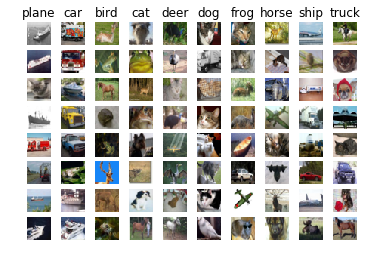

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?
- yes , the misclassified images often show similar traits of color or edge directions as for example the training date of the correct label.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [15]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

best_net = None
learning_rates = [0.5, 0.7, 0.9]
regularization_strengths = [1e-5, 1e-6, 1e-7]
iterations = [1000, 3000, 5000, 10000]
best_val = -1
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
for rate in learning_rates:
    for strength in regularization_strengths:
        for iteration in iterations:
            model = TwoLayerNet(input_dim, hidden_dim, num_classes)
            stats = model.train(X_train_feats, y_train, X_val_feats, y_val,learning_rate=rate, reg=strength, num_iters=iteration, verbose=False)
            print('params: %.4f %.4f %.4f' %(rate, strength, iteration))
            print('train accuracy: %.4f' %stats['train_acc_history'][-1])
            print('validation accuracy: %.4f' %stats['val_acc_history'][-1])   
            if best_val < stats['val_acc_history'][-1]:
                  best_val = stats['val_acc_history'][-1]
                  best_net = model
                  best_stats = stats
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
print('best validation accuracy achieved during cross-validation: %f' % best_val)


params: 0.5000 0.0000 1000.0000
train accuracy: 0.3750
validation accuracy: 0.3700
params: 0.5000 0.0000 3000.0000
train accuracy: 0.6050
validation accuracy: 0.5210
params: 0.5000 0.0000 5000.0000
train accuracy: 0.6600
validation accuracy: 0.5600
params: 0.5000 0.0000 10000.0000
train accuracy: 0.7050
validation accuracy: 0.5860
params: 0.5000 0.0000 1000.0000
train accuracy: 0.4900
validation accuracy: 0.3920
params: 0.5000 0.0000 3000.0000
train accuracy: 0.6750
validation accuracy: 0.5170
params: 0.5000 0.0000 5000.0000
train accuracy: 0.6400
validation accuracy: 0.5480
params: 0.5000 0.0000 10000.0000
train accuracy: 0.5750
validation accuracy: 0.5580
params: 0.5000 0.0000 1000.0000
train accuracy: 0.5350
validation accuracy: 0.4790
params: 0.5000 0.0000 3000.0000
train accuracy: 0.5700
validation accuracy: 0.5350
params: 0.5000 0.0000 5000.0000
train accuracy: 0.7050
validation accuracy: 0.5420
params: 0.5000 0.0000 10000.0000
train accuracy: 0.6700
validation accuracy: 0.5650
p

In [16]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.549
